In [ ]:
%reset

# __ REQUIRED __

## __ sckit-image

In [1]:
pip install -U scikit-image

     |████████████████████████████████| 29.2MB 123kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


## __ module_cs551

In [2]:
#execfile('/content/drive/MyDrive/Colab Notebooks/DL/CS551_Assignment_4/code/module_cs551.py')

#===============================================================
# IMPORTS ======================================================
#===============================================================
print('module_cs551')
import math
import os
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from sklearn.metrics import confusion_matrix
#import keract
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import Model
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

#===============================================================
# PERFORMANCE =================================================
#===============================================================
#------------------------------------------------------------------
# Confusion Matrix
#------------------------------------------------------------------
def _print_header(class_labels):
    g_HSTR=''   # HEADER ROW for printing confusing matrix
    for i in range(0,len(class_labels)):
        g_HSTR+='\t'+str(class_labels[i])
    return  g_HSTR
def _print_rows(cm_row, nos_labels):
    g_RSTR = ''
    for j in range(0,nos_labels):
        g_RSTR += '\t'+ str(cm_row[j])
    return g_RSTR
def print_conf_matrix(conf_matrix, suffix, class_labels):
    g_CMSTR=(suffix+'T\\P' + _print_header(class_labels)+'\n')
    nos_l=len(class_labels)
    for i in range(0,nos_l):
        g_CMSTR+=(suffix+str(class_labels[i]) + _print_rows(conf_matrix[i],nos_l )+'\n')
    return g_CMSTR

#------------------------------------------------------------------
# Performance Measures
#------------------------------------------------------------------
def _get_performance(conf_matrix):
    nos_class = len(conf_matrix[0,:]) # len of 0th row
    perf_measures_array = np.zeros((0,11),dtype ='float64')
    for i in range(0,nos_class):
        
        CLASS_ACTUAL = np.sum(conf_matrix[i,:]) #<---- ROW SUM = NOS TRUE CLASS
        CLASS_PRED = np.sum(conf_matrix[:,i])      #<---- COL SUM = NOS PRED CLASS
        MSUM = np.sum(conf_matrix)  # = TP + FN + FP + TN
        
        # compute TP, TN, FP, FN ---------------------------- 
        TP = conf_matrix[i,i]
        FP =  CLASS_PRED - TP
        FN = CLASS_ACTUAL - TP
        TN =  MSUM- FN - FP - TP #<------------ this methods counts more than true negative
        #TN = np.sum(conf_matrix[np.diag_indices(nos_class)]) - TP..

        #Accuracy #<-= how many samples correctly classifed out of all samples
        ACC = (TP+TN)   /   ( MSUM)  
        
        #Precision = TP/CLASS_PRED    #<- = how many samples correctly predicted as true out of all samples predicted as true
        PRE = (TP)      /   (TP+FP)         #Presicion
        
        #Sensetivity = TP/CLASS_ACTUAL #<- = how many samples correctly predicted as true out of all actually true samples
        SEN = (TP)      /   (TP+FN)         #Sensitivity/Recall
        
        #Specificity #<-= how many samples correctly predicted false out of all samples predicted as false
        SPF = (TN)      /   (TN+FP)         
        
        # F1-Score #<-= 2*TP / (CLASS_ACTUAL + CLASS_PRED) 
        F1S = 2*PRE*SEN /   (PRE+SEN)       #F1 score #<-= harmonic mean of Precision and Sensetivity

        prefi = np.array([CLASS_ACTUAL , CLASS_PRED, TP, FN, FP, TN, ACC, PRE, SEN, SPF, F1S])
        perf_measures_array = np.vstack((perf_measures_array,prefi))
        
    return perf_measures_array, nos_class
def print_performance(conf_matrix, class_labels, do_round=-1):
    #header_string = 'Class\tACC\tPRE\tSEN\tSPF\tF1S'
    header_string = 'Class\t#True\t#Pred\tTPs\tFNs\tFPs\tTNs\tACC\tPRE\tSEN\tSPF\tF1S'
    perf_measures, nos_class = _get_performance(conf_matrix)
    if len(class_labels)!=nos_class:
        print('WARNING:: Class label count mismatch!! Cannot print performance')
        return -1
    #nos_class = len(perf_measures[:,0])
    print('Performance for '+str(nos_class)+' classes')
    print (header_string)
    for i in range(0, nos_class):
        if do_round<0:
          perf_i = perf_measures [i,:]
        else:
          perf_i = np.round(perf_measures [i,:],do_round)
          
        print(
              str(class_labels[i])+'\t'+
              str(perf_i[0])+'\t'+
              str(perf_i[1])+'\t'+
              str(perf_i[2])+'\t'+
              str(perf_i[3])+'\t'+
              str(perf_i[4])+'\t'+
              str(perf_i[5])+'\t'+
              str(perf_i[6])+'\t'+
              str(perf_i[7])+'\t'+
              str(perf_i[8])+'\t'+
              str(perf_i[9])+'\t'+
              str(perf_i[10])
              )
    return nos_class
	
#===============================================================
# MNIST DATA HELPER ==============================================
#===============================================================
# Load Training Images
def _mnist_images(IMAGE_FILE):
  print('> Reading Images from',IMAGE_FILE )
  _FILE_IMAGE = open(IMAGE_FILE,"rb" ) 

  # first 4 byte = magic number
  _magic = int.from_bytes(_FILE_IMAGE.read(4), "big")
  print('Magic Number\t',_magic)

  # next 4 byte = nos items
  _nos_images = int.from_bytes(_FILE_IMAGE.read(4), "big")
  print('Nos Images\t',_nos_images)

  # next 4 byte = image dimension Rows
  _nos_rows= int.from_bytes(_FILE_IMAGE.read(4), "big")
  print('Nos Rows\t',_nos_rows)

  # next 4 byte = image dimension Cols
  _nos_cols = int.from_bytes(_FILE_IMAGE.read(4), "big")
  print('Nos Cols\t',_nos_cols)

  _nos_bytes = _nos_rows*_nos_cols
  print('Bytes per Image\t',_nos_bytes)

  # next onwards.... one image per _nos_bytes bytes
  _buffer = np.frombuffer(_FILE_IMAGE.read(_nos_bytes*_nos_images), 
                          dtype=np.uint8, count=_nos_bytes*_nos_images, offset=0)
  print('ImageBuffer:',_buffer.dtype, _buffer.shape)
  _buffer = _buffer.reshape(_nos_images,_nos_rows,_nos_cols)
  print('ImageBuffer Reshaped:',_buffer.dtype, _buffer.shape)

  _FILE_IMAGE.close()
  print('Done\n' )
  return _buffer, _nos_images, _nos_rows, _nos_cols

def _mnist_labels(LABEL_FILE):
  print('> Reading Labels from',LABEL_FILE )
  _FILE_LABEL = open(LABEL_FILE,"rb" ) 

  # first 4 byte = magic number
  _magic = int.from_bytes(_FILE_LABEL.read(4), "big")
  print('Magic Number\t',_magic)

  # next 4 byte = nos items
  _nos_labels = int.from_bytes(_FILE_LABEL.read(4), "big")
  print('Nos Labels\t',_nos_labels)

  # next onwards.... one image per _nos_bytes bytes
  _buffer = np.frombuffer(_FILE_LABEL.read(_nos_labels), 
                          dtype=np.uint8, count=_nos_labels, offset=0)
  print('LabelBuffer:',_buffer.dtype, _buffer.shape)

  _FILE_LABEL.close()
  print('Done\n' )
  return _buffer, _nos_labels

#===============================================================
# IMAGE TRANSFORMS =============================================
#===============================================================

# flips horizontal and vertical
def _aug_flip(imageA, horz=True, vert=True):
  res = imageA
  if vert:
    res = np.flip(res,1)
  if horz:
    res = np.flip(res,2)
  return res

def _aug_shift(imageA, shiftA):
  imageT = []
  for i in range(0, len(imageA)):
    imageT.append(np.roll(np.roll(imageA[i], shiftA[i,0],axis=0),shiftA[i,1],axis=1))
  return imageT

def _aug_rotate(imageA, radA, opx, opy):
  imageT = [] #<<--- appending to list is faster than vstacking
  cpx,cpy = int(opx/2), int(opy/2)
  for i in range(0, len(imageA)):
    imageT.append(transform.warp(imageA[i],
                                       transform.AffineTransform(matrix= _get_rotation_matrix_wrtp(radA[i], cpx,cpy)), 
                                       output_shape=(opx, opy)))
  return imageT

# tranformation matrices for translation and rotation 
def _get_translation_matrix(tX,tY):
  return np.array([[1,0,tX],[0,1,tY],[0,0,1]])

def _get_rotation_matrix_wrtc(tH):
  return np.array([[math.cos(tH), -math.sin(tH),  0],
                   [math.sin(tH), math.cos(tH),   0],
                   [0,            0,              1]])
  
def _get_rotation_matrix_wrtp(tH, tX, tY):
  # rotation wrt to a point = translate to center - rotate - translate back to poit
  t1 = _get_translation_matrix(-tX, -tY)
  tr = _get_rotation_matrix_wrtc(tH)
  t2 = _get_translation_matrix(tX, tY)
  return np.matmul(t2, np.matmul(tr,t1))

#===============================================================
# Model Definition =================================================
#===============================================================

def get_model(print_summary, model_name, conv_kernels, conv_kernel_size, dense_size):
    global _ishape, _nos_classes
  
    inputL = Input( shape=_ishape, name = "input" )

    conv_1 =  Conv2D(conv_kernels,                                       #kernels, 
                          kernel_size=conv_kernel_size,                  #kernel_size
                          strides=(1,1), 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_1') (inputL) 
    
  
    norm_2 = tf.keras.layers.BatchNormalization(
                                        axis=-1,
                                        momentum=0.99,
                                        epsilon=0.001,
                                        center=True,
                                        scale=True,
                                        beta_initializer="zeros",
                                        gamma_initializer="ones",
                                        moving_mean_initializer="zeros",
                                        moving_variance_initializer="ones",
                                        beta_regularizer=None,
                                        gamma_regularizer=None,
                                        beta_constraint=None,
                                        gamma_constraint=None,
                                        renorm=False,
                                        renorm_clipping=None,
                                        renorm_momentum=0.99,
                                        fused=None,
                                        trainable=True,
                                        virtual_batch_size=None,
                                        adjustment=None,
                                        name='norm_2') (conv_1)
    

    flat_ = Flatten(data_format=None,name='flat_') (norm_2)
    den_3 = Dense(dense_size, activation=tf.nn.leaky_relu, name = "den_3")(flat_)

    outputL = Dense(_nos_classes, activation=tf.nn.softmax, name = "output")(den_3)

    model=Model(inputs=inputL, outputs=outputL, name=model_name)
    #-------------------------------------
    if print_summary:
        print(model.summary())
    return model
# =========================================================================================


print('Done!')
		

module_cs551
Done!


# [] DATASET LOAD []

Dataset : THE MNIST DATABASE of handwritten digit http://yann.lecun.com/exdb/mnist/

In [3]:
MODEL_DIR = '/content/drive/MyDrive/Colab Notebooks/DL/CS551_Assignment_4/model' # for saving w8s
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/DL/CS551_Assignment_4/data'  # for reading data
train_x, nos_train_x, dimH_train_x, dimW_train_x = _mnist_images(os.path.join(DATA_DIR, 'train-images.idx3-ubyte'))
train_y, nos_train_y = _mnist_labels(os.path.join(DATA_DIR, 'train-labels.idx1-ubyte'))
test_x, nos_test_x, dimH_test_x, dimW_test_x = _mnist_images(os.path.join(DATA_DIR, 't10k-images.idx3-ubyte'))
test_y, nos_test_y = _mnist_labels(os.path.join(DATA_DIR, 't10k-labels.idx1-ubyte'))

# ---------------------------------------- input shape
_ishape = (dimH_train_x, dimW_train_x,1)
print('Input Shape:\t',_ishape)
# ---------------------------------------- classes
_nos_classes = 10
g_LABELS = np.arange(0,_nos_classes,1)
print('Classes:\t#',_nos_classes, g_LABELS)

> Reading Images from /content/drive/MyDrive/Colab Notebooks/DL/CS551_Assignment_4/data/train-images.idx3-ubyte
Magic Number	 2051
Nos Images	 60000
Nos Rows	 28
Nos Cols	 28
Bytes per Image	 784
ImageBuffer: uint8 (47040000,)
ImageBuffer Reshaped: uint8 (60000, 28, 28)
Done

> Reading Labels from /content/drive/MyDrive/Colab Notebooks/DL/CS551_Assignment_4/data/train-labels.idx1-ubyte
Magic Number	 2049
Nos Labels	 60000
LabelBuffer: uint8 (60000,)
Done

> Reading Images from /content/drive/MyDrive/Colab Notebooks/DL/CS551_Assignment_4/data/t10k-images.idx3-ubyte
Magic Number	 2051
Nos Images	 10000
Nos Rows	 28
Nos Cols	 28
Bytes per Image	 784
ImageBuffer: uint8 (7840000,)
ImageBuffer Reshaped: uint8 (10000, 28, 28)
Done

> Reading Labels from /content/drive/MyDrive/Colab Notebooks/DL/CS551_Assignment_4/data/t10k-labels.idx1-ubyte
Magic Number	 2049
Nos Labels	 10000
LabelBuffer: uint8 (10000,)
Done

Input Shape:	 (28, 28, 1)
Classes:	# 10 [0 1 2 3 4 5 6 7 8 9]


# [] DATASET AUGUMENT []

### FLIP

In [4]:
# > flipping images > for each image, flip in 3 diff ways

train_x_flipH = _aug_flip(train_x, horz=True, vert=False) # horizontal flip
train_x_flipV = _aug_flip(train_x, horz=False, vert=True) # verical flip
train_x_flipD = _aug_flip(train_x, horz=True, vert=True) # horizontal + vertical flip

test_x_flipH = _aug_flip(test_x, horz=True, vert=False) # horizontal flip
test_x_flipV = _aug_flip(test_x, horz=False, vert=True) # verical flip
test_x_flipD = _aug_flip(test_x, horz=True, vert=True) # horizontal + vertical flip

### ROTATE

In [5]:
# > rotating images > for each image, rotate by random angle b/w -180 to 180

rand_ang_train = math.pi*(np.random.random(size=nos_train_x)*2 - 1) # random scaled b/w -180 to 180
train_x_rotR = np.array(_aug_rotate(train_x,  rand_ang_train, dimH_train_x, dimW_train_x))

rand_ang_test = math.pi*(np.random.random(size=nos_test_x)*2 - 1) # random scaled b/w -180 to 180
test_x_rotR = np.array(_aug_rotate(test_x,  rand_ang_test, dimH_test_x, dimW_test_x))

### SHIFT

In [6]:
# > shift images > for each image, shift by random amount +/- 5 in either directions

rand_delta_train = (10*(np.random.random(size=(nos_train_x,2))*2 - 1)).astype('int')
train_x_shift = np.array(_aug_shift(train_x,  rand_delta_train))

rand_delta_test = (10*(np.random.random(size=(nos_test_x,2))*2 - 1)).astype('int')
test_x_shift = np.array(_aug_shift(test_x,  rand_delta_test))

# {} EXP 10 {}

##__PREPARE

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~
_exp_name = 'EXP_10'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ---------------------------------------- model params
_model_name = 'exp_10'
_conv_kernels, _kernel_size = 64, (3,3)
_dense_size = 128
_cost = 'sparse_categorical_crossentropy'
_opt = tf.keras.optimizers.SGD()  # clipnorm=1 <--- for clipping gradient
# ---------------------------------------- training params
_batch_size = 500
_epochs = 20
_val_split = 0.1
# ---------------------------------------- LRS callback handler #print('LRS_Callback @epoch:', e, 'LR:', lr) # verbose
def _deltaLR(e,lr):
  global hist_lr, hist_learn
  hist_lr[hist_learn] = lr #<--record learning rate
  hist_learn+=1

  #----------------------------------------------------
  #new_lr = lr # not controlled
  if e<=5:
    new_lr = lr   #keep unchanged 
  elif e<=10:
    new_lr = lr*0.80
  else:
    new_lr = lr/e # decay


  #----------------------------------------------------
  return new_lr

#=============================================================
# ---------------------------------------- Training Event handler
def _record_batch(b_acc, b_loss):
  global hist_bp, hist_batch
  hist_bp[hist_batch,0],hist_bp[hist_batch,1] = b_acc, b_loss
  hist_batch+=1


##__CALLBACKS

In [8]:

#===============================================================
# CALLBACK =====================================================
#===============================================================
cb_LRS = tf.keras.callbacks.LearningRateScheduler(_deltaLR, verbose=0)
cb_BASE = tf.keras.callbacks.LambdaCallback(
        on_train_begin =  None, #lambda logs: _start_train() ,
        on_epoch_begin =  None, #lambda epoch,logs: _start_epoch(epoch) ,
        on_batch_begin =  None, #lambda batch,logs: _start_batch(batch),
        on_batch_end =    lambda batch,logs: _record_batch(logs['accuracy'], logs['loss']) ,
        on_epoch_end =    None, #lambda epoch,logs: _epoch_end(epoch, logs) ,
        on_train_end =    None #lambda logs: _print_results(logs['accuracy'], logs['loss'],logs['val_accuracy'], logs['val_loss'])
        )
cb_ES_val_acc = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',  #monitor: Quantity to be monitored.
        min_delta=0.00001,  #min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
        patience=5,  #patience: Number of epochs with no improvement after which training will be stopped.
        verbose=1,  #verbose: verbosity mode.
        mode='auto',  #mode: One of {"auto", "min", "max"}. 
                      #In min mode, training will stop when the quantity monitored has stopped decreasing; 
                      #in "max" mode it will stop when the quantity monitored has stopped increasing; 
                      #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
        baseline=None,  #baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
        restore_best_weights=False #restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
        )

cb_ES_val_loss = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  #monitor: Quantity to be monitored.
        min_delta=0.00001,  #min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
        patience=5,  #patience: Number of epochs with no improvement after which training will be stopped.
        verbose=1,  #verbose: verbosity mode.
        mode='auto',  #mode: One of {"auto", "min", "max"}. 
                      #In min mode, training will stop when the quantity monitored has stopped decreasing; 
                      #in "max" mode it will stop when the quantity monitored has stopped increasing; 
                      #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
        baseline=None,  #baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
        restore_best_weights=False #restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
        )

cb_ES_loss = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  #monitor: Quantity to be monitored.
        min_delta=0.00001,  #min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
        patience=3,  #patience: Number of epochs with no improvement after which training will be stopped.
        verbose=1,  #verbose: verbosity mode.
        mode='auto',  #mode: One of {"auto", "min", "max"}. 
                      #In min mode, training will stop when the quantity monitored has stopped decreasing; 
                      #in "max" mode it will stop when the quantity monitored has stopped increasing; 
                      #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
        baseline=None,  #baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
        restore_best_weights=True #restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
        )

cb_ES_acc = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy',  #monitor: Quantity to be monitored.
        min_delta=0.00001,  #min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
        patience=3,  #patience: Number of epochs with no improvement after which training will be stopped.
        verbose=1,  #verbose: verbosity mode.
        mode='auto',  #mode: One of {"auto", "min", "max"}. 
                      #In min mode, training will stop when the quantity monitored has stopped decreasing; 
                      #in "max" mode it will stop when the quantity monitored has stopped increasing; 
                      #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
        baseline=None,  #baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
        restore_best_weights=True #restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
        )
cb_listr = [ 
            cb_LRS, 
            cb_BASE, 
            cb_ES_val_loss, 
            cb_ES_val_acc, 
            cb_ES_loss, 
            cb_ES_acc, 
            ]


##__BEGIN

# == EXP_10 == #

Model Name:	 exp_10
Conv Kernels:	 64  of size  (3, 3)
Dense Size:	 128
Cost/Loss:	 sparse_categorical_crossentropy
Optimizer:	 <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f5cf209a810>


Model: "exp_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 26, 26, 64)        256       
_________________________________________________________________
flat_ (Flatten)              (None, 43264)             0         
_________________________________________________________________
den_3 (Dense)                (None, 128)               5537920   
_________________________

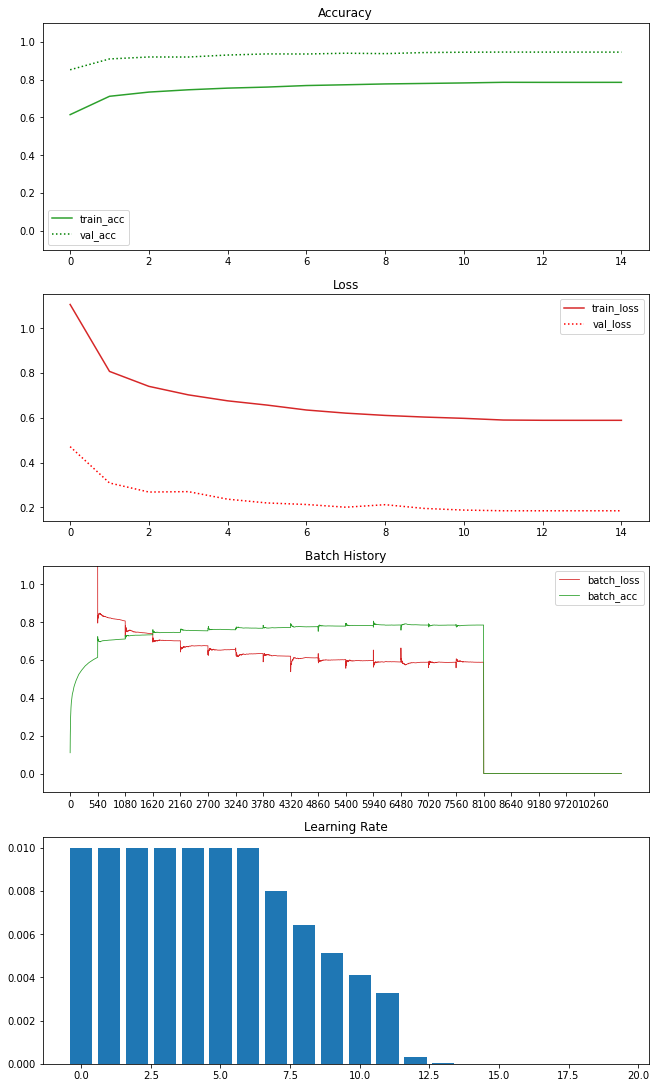

Saved Model Weights at : /content/drive/MyDrive/Colab Notebooks/DL/CS551_Assignment_4/model/exp_10.h5

Testing Model:	 exp_10 on samples: (50000, 28, 28) (50000,)
1563/1563 [==============================] - 28s 18ms/step - loss: 0.6139 - accuracy: 0.7742
Accuracy: 77.42

	Confusion Matrix [N/A]
T\P	0	1	2	3	4	5	6	7	8	9
0	3781	980	21	2	22	14	41	10	15	14
1	0	5625	17	2	5	3	5	13	3	2
2	30	1038	3744	88	6	117	32	58	30	17
3	10	1011	79	3770	0	106	7	20	29	18
4	10	988	1	0	3761	0	34	18	9	89
5	11	898	100	118	1	3240	24	28	20	20
6	60	977	45	2	48	26	3537	37	19	39
7	9	1062	53	34	20	12	14	3855	14	67
8	39	975	25	30	5	20	11	20	3690	55
9	29	1027	17	27	85	32	36	50	35	3707

Performance for 10 classes
Class	#True	#Pred	TPs	FNs	FPs	TNs	ACC	PRE	SEN	SPF	F1S
0	4900.0	3979.0	3781.0	1119.0	198.0	44902.0	0.97366	0.95024	0.77163	0.99561	0.85167
1	5675.0	14581.0	5625.0	50.0	8956.0	35369.0	0.81988	0.38578	0.99119	0.79795	0.55539
2	5160.0	4102.0	3744.0	1416.0	358.0	44482.0	0.96452	0.91273	0.72558	0.99202	0.80846
3	5050.

In [9]:
print('# ==',_exp_name, '== #\n')
print('Model Name:\t',_model_name)
print('Conv Kernels:\t',_conv_kernels,' of size ',_kernel_size )
print('Dense Size:\t', _dense_size)
print('Cost/Loss:\t', _cost)
print('Optimizer:\t',str(_opt))

#@---------------------------------------------------------->> GET DATA
_dx, _dy, _tx, _ty = train_x, train_y, test_x, test_y
# augument mied
_dx, _dy = np.vstack((_dx,train_x_shift)), np.hstack((_dy,train_y))
_tx, _ty = np.vstack((_tx,test_x_shift)), np.hstack((_ty,test_y))

_dx, _dy = np.vstack((_dx,train_x_rotR)), np.hstack((_dy,train_y))
_tx, _ty = np.vstack((_tx,test_x_rotR)), np.hstack((_ty,test_y))

_dx, _dy = np.vstack((_dx,train_x_flipH)), np.hstack((_dy,train_y))
_dx, _dy = np.vstack((_dx,train_x_flipV)), np.hstack((_dy,train_y))
_tx, _ty = np.vstack((_tx,test_x_flipH)), np.hstack((_ty,test_y))
_tx, _ty = np.vstack((_tx,test_x_flipV)), np.hstack((_ty,test_y))

#@---------------------------------------------------------->> GET BATCH INFO
_nos_batch_per_epoch = math.ceil(len(_dx)/_batch_size)
_nos_batch_per_epoch = math.ceil(_nos_batch_per_epoch*(1-_val_split))
_nos_batches = _epochs * _nos_batch_per_epoch
_trange = np.arange(0,_nos_batches,_nos_batch_per_epoch)
#hist_batch, hist_bp, hist_lr = 0, None, None
hist_batch,hist_learn = 0,0
hist_bp = np.zeros((_nos_batches,2))  #<<-------- Batch history
hist_lr = np.zeros(_epochs)           #<<-------- Learn Rate history

#@---------------------------------------------------------->> GET MODEL
print('\n')
model = get_model(True, _model_name, _conv_kernels, _kernel_size, _dense_size)
model.compile(loss=_cost, optimizer=_opt, metrics=['accuracy'])

#@---------------------------------------------------------->> TRAIN MODEL
timestamp_start = datetime.datetime.now()
print('\n\nTraining Model:\t', model.name, 
      '\nTotal samples:\t',_dy.shape,
      '\nBatch size:    \t',_batch_size,
      '\nVal Split \t',_val_split,
      '\nNos. epochs:  \t',_epochs,
      '\nNos. batches: \t',_nos_batches,'\n'
      )
history = model.fit(
                    _dx, _dy,
                    batch_size=_batch_size,
                    epochs=_epochs,
                    callbacks=cb_listr,
                    validation_split=_val_split,
                    shuffle=True,
                    verbose=1)


print('\nElapsed time = ',datetime.datetime.now() - timestamp_start)


#@---------------------------------------------------------->> PLOT TRAINING RESULTS
fig, axs = plt.subplots(4, 1, figsize=(9,15),  constrained_layout=True)

axs[0].set_title('Accuracy')
axs[0].set_ylim((-.1,1.1))
axs[0].plot(history.history['accuracy'],color='tab:green', label='train_acc')
axs[0].plot(history.history['val_accuracy'],color='green', linestyle='dotted', label='val_acc')
axs[0].legend()

axs[1].set_title('Loss')
axs[1].plot(history.history['loss'],color='tab:red', label='train_loss')
axs[1].plot(history.history['val_loss'],color='red', linestyle='dotted',label='val_loss')
axs[1].legend()

axs[2].set_title('Batch History')
axs[2].set_ylim((-.1,1.1))
axs[2].plot(hist_bp[:,1],color='tab:red', label='batch_loss', linewidth=0.8)
axs[2].plot(hist_bp[:,0],color='tab:green', label='batch_acc', linewidth=0.8)
axs[2].set_xticks(_trange)
axs[2].legend()

axs[3].set_title('Learning Rate')
axs[3].bar(np.arange(0,len(hist_lr)), hist_lr)

plt.show()


#@---------------------------------------------------------->> SAVE MODEL W8
model_path = os.path.join(MODEL_DIR, model.name +'.h5')
model.save_weights(model_path)
print('Saved Model Weights at : '+ str(model_path))


#@---------------------------------------------------------->> TEST MODEL
print('\nTesting Model:\t', model.name, 'on samples:',_tx.shape,_ty.shape)

#@----------------------------------------->> Eval
_, accuracy = model.evaluate(_tx, _ty )
print('Accuracy: %.2f' % (accuracy*100))

#@----------------------------------------->> Predict
predictions = model.predict(_tx)
predictions_class=np.argmax(predictions, axis=-1)

#@----------------------------------------->> conf matrix and performance measures
matrix = confusion_matrix( _ty,  predictions_class,   g_LABELS )
print('\n\tConfusion Matrix [N/A]') 
print(print_conf_matrix( matrix, '', g_LABELS)) 
print_performance( matrix ,g_LABELS, do_round=5)

#@----------------------------------------->> further investigation if needed
pred_correct = np.where(predictions_class==_ty)[0]
pred_wrong = np.where(predictions_class!=_ty)[0]
pC = len(pred_correct)
pW = len(pred_wrong)
print('')
assert ((pC+pW)==len(_ty))
print('Total Predictions\t',(pC+pW))
print('Correct Predictions\t', pC,'\t', round((100*pC)/(pC+pW),2),'%')
print('Incorrect Predictions\t', pW,'\t', round((100*pW)/(pC+pW),2),'%')
#@---------------------------------------------------------->> END
timestamp_dur = datetime.datetime.now() - timestamp_start
print('\nElapsed time = ' + str(timestamp_dur))



---



# _ end _